In [1]:
import os
import re
import string
import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import *
from indoNLP.preprocessing import *
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [2]:
if os.path.isdir("../data/"):
    main_dir = "../"
else:
    main_dir = "https://raw.githubusercontent.com/Hyuto/skripsi/master/"

SEED = 2022

In [3]:
data = pd.read_csv(main_dir + "data/sample-data.csv")
data.head()

,date,url,user,content,label
0,2021-09-02 01:39:05+00:00,https://twitter.com/no_nykrstnd/status/1433243...,no_nykrstnd,"-Dari hasil monitoring, calon Vaksin Merah Put...",0.0
1,2021-07-15 06:09:36+00:00,https://twitter.com/DakwahMujahidah/status/141...,DakwahMujahidah,[PODCAST] Ngomong Politik - Ilusi Penguatan Ke...,0.0
2,2021-07-05 08:57:50+00:00,https://twitter.com/gamisjohor/status/14119725...,gamisjohor,3. GAMIS menyambut baik saranan daripada YAB P...,2.0
3,2021-09-09 09:17:58+00:00,https://twitter.com/inyesaw/status/14358952423...,inyesaw,@txtdaribogor Abis vaksin terbitlah positif covid,4.0
4,2021-01-02 04:37:14+00:00,https://twitter.com/pringgolakseno/status/1345...,pringgolakseno,"Gambling, vaksin sama ga divaksin.\nGa divaksi...",4.0


In [4]:
data.dropna(inplace=True)
data["date"] = pd.to_datetime(data["date"]).dt.tz_localize(None)
data["label"] = data["label"].astype(int)
# data = data[data["label"] > 0]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 2999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     3000 non-null   datetime64[ns]
 1   url      3000 non-null   object        
 2   user     3000 non-null   object        
 3   content  3000 non-null   object        
 4   label    3000 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 140.6+ KB


In [5]:
STEMMER = StemmerFactory().create_stemmer()


def preprocessing(text):
    text = text.lower()
    text = re.sub(r"\s+", " ", text, flags=re.UNICODE)  # remove whitespace
    text = emoji_to_words(text)  # remove emoji
    text = unicodedata.normalize("NFD", text).encode("ascii", "ignore").decode("ascii")
    text = remove_html(text)  # remove html tags
    text = remove_url(text)  # remove url
    # text = re.sub(r"(?<![\w@])@([\w@]+(?:[.!][\w@]+)*)", " ", text)
    text = replace_word_elongation(text)  # replace WE
    text = replace_slang(text)  # replace slang words
    text = text.translate(str.maketrans(string.digits, " " * len(string.digits)))  # remove numbers
    text = text.translate(
        str.maketrans(string.punctuation, " " * len(string.punctuation))
    )  # remove punctuation
    text = " ".join(text.split())
    text = STEMMER.stem(text)
    return " ".join(text.split())


data["cleaned"] = [preprocessing(x) for x in tqdm(data["content"].values)]

  0%|          | 0/3000 [00:00<?, ?it/s]

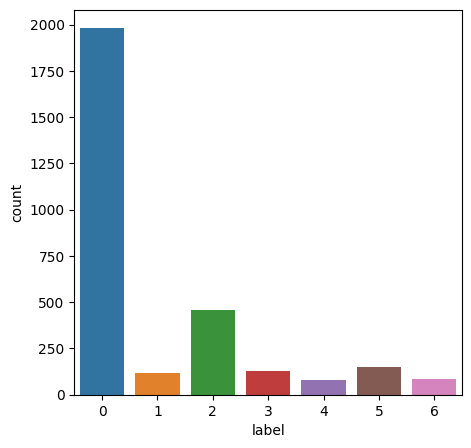

In [6]:
plt.figure(figsize=(5, 5))
sns.countplot(data=data, x="label")
plt.show()

In [7]:
pipe = Pipeline(
    [
        ("tf-idf", TfidfVectorizer()),
        ("svm", SVC(probability=True, class_weight="balanced", random_state=SEED)),
    ]
)

cv = StratifiedKFold(shuffle=True, random_state=SEED)
main_params = {
    "tf-idf__max_features": [1000, 2000, 3000, 4000, 5000],
    "svm__C": np.arange(0.2, 4, 0.1),
}
param_grid = [
    {**main_params, "svm__kernel": ["linear", "rbf"]},
    {
        **main_params,
        "svm__coef0": np.arange(1, 2, 0.1),  # np.arange(-0.5, 2, 0.1),
        "svm__kernel": ["poly"],
    },
]

# Run Grid Search approximately 2Hr
# search = GridSearchCV(pipe, param_grid, scoring="f1_weighted", cv=cv, n_jobs=-1, verbose=1)
# search.fit(data["cleaned"].values, data["label"].values)
# search_df = pd.DataFrame(search.cv_results_) # result to df
# search_df.to_csv("CV.csv", index=False)

search_df = pd.read_csv(main_dir + "models/CV-log.csv")  # read CV score
(
    search_df.sort_values(["mean_test_score", "std_test_score"], ascending=[False, True])
    .drop(
        [
            "mean_fit_time",
            "std_fit_time",
            "mean_score_time",
            "std_score_time",
            "split0_test_score",
            "split1_test_score",
            "split2_test_score",
            "split3_test_score",
            "split4_test_score",
        ],
        axis=1,
    )
    .head(40)
)

,param_svm__C,param_svm__kernel,param_tf-idf__max_features,param_svm__coef0,params,mean_test_score,std_test_score,rank_test_score
0,0.4,rbf,1000,NaN,"{'svm__C': 0.4000000000000001, 'svm__kernel': ...",0.666600,0.009923,1
1,0.9,rbf,1000,NaN,"{'svm__C': 0.9000000000000001, 'svm__kernel': ...",0.666196,0.007695,2
2,0.7,rbf,1000,NaN,"{'svm__C': 0.7000000000000002, 'svm__kernel': ...",0.666073,0.008444,3
3,0.8,rbf,2000,NaN,"{'svm__C': 0.8000000000000003, 'svm__kernel': ...",0.665581,0.010371,4
4,1.3,linear,5000,NaN,"{'svm__C': 1.3000000000000003, 'svm__kernel': ...",0.665114,0.007610,5
5,2.1,linear,5000,NaN,"{'svm__C': 2.100000000000001, 'svm__kernel': '...",0.664862,0.009984,6
6,1.8,linear,5000,NaN,"{'svm__C': 1.8000000000000007, 'svm__kernel': ...",0.664852,0.009358,7
7,2.0,linear,5000,NaN,"{'svm__C': 2.000000000000001, 'svm__kernel': '...",0.664764,0.010648,8
8,0.8,rbf,1000,NaN,"{'svm__C': 0.8000000000000003, 'svm__kernel': ...",0.664558,0.008720,9
9,1.7,linear,5000,NaN,"{'svm__C': 1.7000000000000006, 'svm__kernel': ...",0.664430,0.007852,10


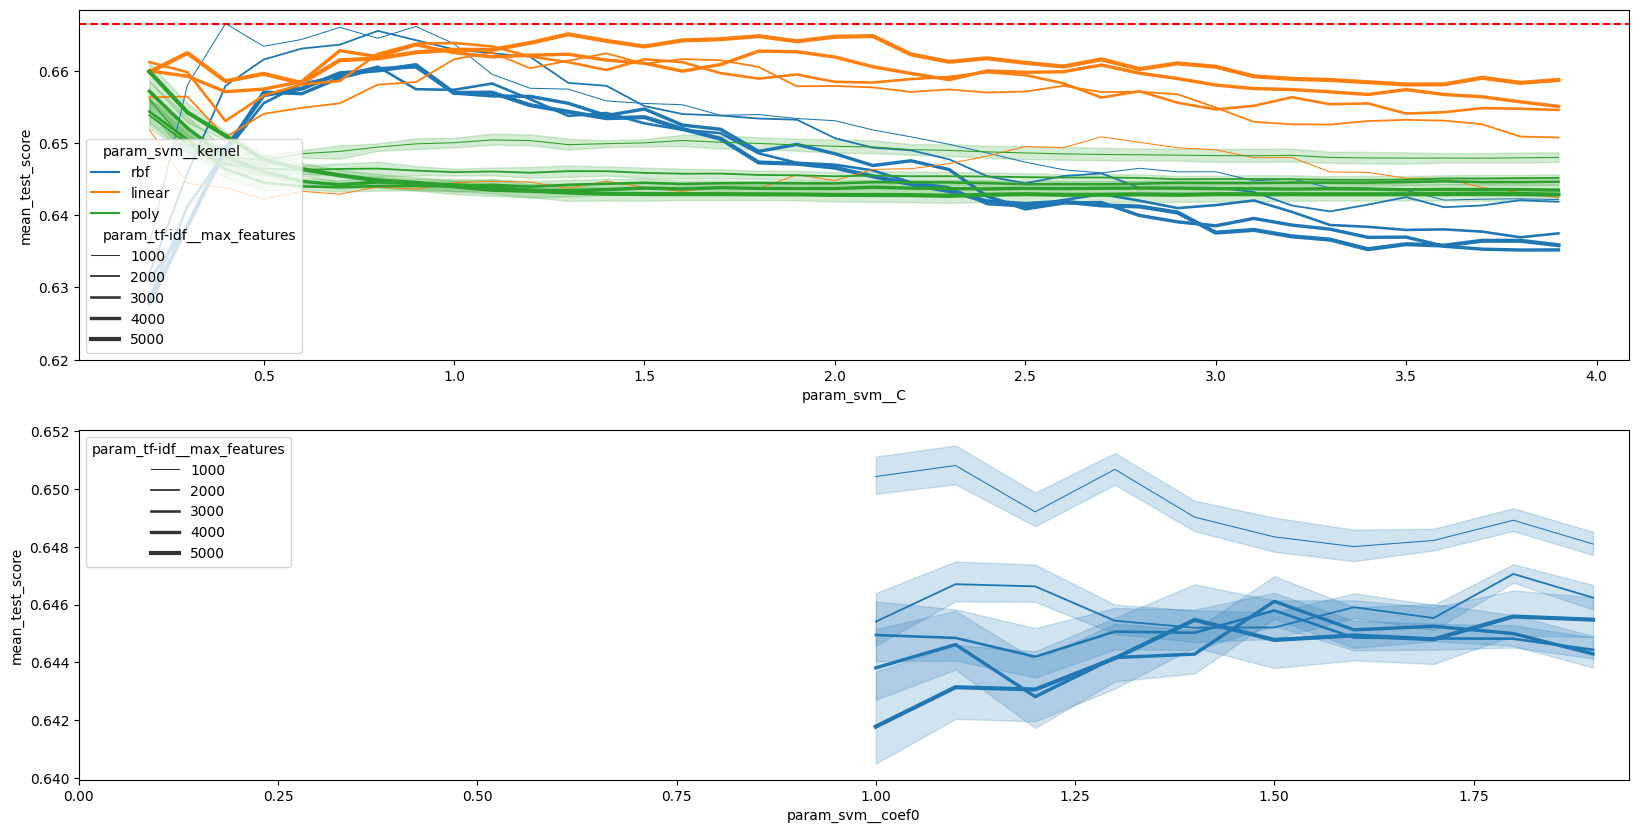

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
sns.lineplot(
    data=search_df,
    x="param_svm__C",
    y="mean_test_score",
    hue="param_svm__kernel",
    size="param_tf-idf__max_features",
    ax=ax1,
)
ax1.axhline(y=search_df["mean_test_score"].max(), color="r", linestyle="--")
ax1.set_ylim(0.62)
sns.lineplot(
    data=search_df.query("param_svm__kernel == 'poly'"),
    x="param_svm__coef0",
    y="mean_test_score",  # hue="param_svm__coef0",
    size="param_tf-idf__max_features",
    ax=ax2,
)
ax2.set_xlim(0)
plt.show()

In [9]:
pipe = Pipeline(
    [
        ("tf-idf", TfidfVectorizer(max_features=5000)),
        (
            "svm",
            SVC(
                C=1.3, kernel="linear", probability=True, class_weight="balanced", random_state=SEED
            ),
        ),
    ]
)

scores = cross_val_score(
    pipe, data["cleaned"].values, data["label"].values, scoring="f1_weighted", cv=cv
)
scores.mean()

0.6651137088649659

In [10]:
pipe = Pipeline(
    [
        ("tf-idf", TfidfVectorizer(max_features=5000)),
        (
            "svm",
            SVC(
                C=1.3, kernel="linear", probability=True, class_weight="balanced", random_state=SEED
            ),
        ),
    ]
)

x_train, x_test, y_train, y_test = train_test_split(
    data["cleaned"].values,
    data["label"].values,
    test_size=0.2,
    random_state=1000,
    stratify=data["label"].values,
)

pipe.fit(x_train, y_train)
pd.DataFrame(classification_report(y_test, pipe.predict(x_test), output_dict=True)).T

,precision,recall,f1-score,support
0,0.859155,0.770202,0.812250,396.000000
1,0.166667,0.173913,0.170213,23.000000
2,0.542373,0.695652,0.609524,92.000000
3,0.281250,0.346154,0.310345,26.000000
4,0.250000,0.187500,0.214286,16.000000
5,0.265306,0.433333,0.329114,30.000000
6,0.300000,0.176471,0.222222,17.000000
accuracy,0.668333,0.668333,0.668333,0.668333
macro avg,0.380679,0.397604,0.381136,600.000000
weighted avg,0.697214,0.668333,0.677985,600.000000


In [11]:
from onnx.checker import check_model
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import StringTensorType

os.makedirs("output", exist_ok=True)

initial_type = [("words", StringTensorType([None, 1]))]
options = {"svm": {"zipmap": False}}
onnx_model = convert_sklearn(pipe, initial_types=initial_type, options=options)
with open("output/model.onnx", "wb") as writer:
    writer.write(onnx_model.SerializeToString())
check_model(onnx_model)

!python -m onnxruntime.tools.convert_onnx_models_to_ort "output/model.onnx"

Converting models with optimization style 'Fixed' and level 'all'
Converting optimized ONNX model /home/hyuto/skripsi/notebook/output/model.onnx to ORT format model /home/hyuto/skripsi/notebook/output/model.ort
Converted 1/1 models successfully.
Generating config file from ORT format models with optimization style 'Fixed' and level 'all'
2023-01-08 11:57:18,512 ort_format_model.utils [INFO] - Created config in /home/hyuto/skripsi/notebook/output/model.required_operators.config
Converting models with optimization style 'Runtime' and level 'all'
Converting optimized ONNX model /home/hyuto/skripsi/notebook/output/model.onnx to ORT format model /home/hyuto/skripsi/notebook/output/model.with_runtime_opt.ort
Converted 1/1 models successfully.
Converting models again without runtime optimizations to generate a complete config file. These converted models are temporary and will be deleted.
Converting optimized ONNX model /home/hyuto/skripsi/notebook/output/model.onnx to ORT format model /home/